In [1]:
import pickle as pic
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk.data
from sklearn.model_selection import train_test_split

from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.optimizers import SGD

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keenan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def save_obj(obj, name):
    with open(name, 'wb') as f:
        pic.dump(obj, f, pic.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name, 'rb') as f:
        return pic.load(f, encoding='latin1')

In [3]:
ten_k = load_obj('../data/tmdb_df_10k.pickle')

In [4]:
def df_overview_clean(df):
    ret_df = df.copy()
    return ret_df[['title', 'genres', 'overview']]

In [5]:
ten_k_over = df_overview_clean(ten_k)

In [6]:
classes = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
           'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
            'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']

In [7]:
def genre_extract(genre_dic):
    ret_genres = []
    for dic in genre_dic:
        ret_genres.append(dic['name'])
    return ret_genres

def assign_genre_vector(row_genres, all_classes):
    ret_list = []
    genre_list = genre_extract(row_genres)
    for genre in all_classes:
        if genre in genre_list:
            ret_list.append(1)
        else:
            ret_list.append(0)
    return ret_list           

In [8]:
ten_k_vec = pd.DataFrame(columns=['title', 'genres', 'overview', 'genre_vec', 'all_genres'])
for row in zip(ten_k_over['title'], ten_k_over['genres'], ten_k_over['overview']):
    genre_vec = assign_genre_vector(row[1], classes)
    genres = genre_extract(row[1])
    
    #had to throw this in for the vectorization process-later
    overview = row[2]
    if row[2] == None or not row[2]:
        overview = 'a'
    ten_k_vec = ten_k_vec.append({'title':row[0], 'genres':row[1], 'overview':overview, 'genre_vec':genre_vec, 'all_genres':genres, 'sin_gen':genres[0]}, ignore_index=True)

In [9]:
#set our vectorization
vectorizer = CountVectorizer(stop_words=stopwords.words("english"),
    max_df = 0.9, 
    min_df = 5, 
    dtype=np.float32 )

corpus = ten_k_vec['overview'].values
X = vectorizer.fit_transform(corpus).toarray()
ys = MultiLabelBinarizer().fit_transform(ten_k_vec['all_genres'])
#ys = five_k_vec['sin_gen']

In [10]:
uni_classes = [list(x) for x in set(tuple(x) for x in ten_k_vec['all_genres'].tolist())]

Basic Nueral Network

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,ys,test_size=0.3)

In [12]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512
num_classes = len(classes)
# number of iterations over the complete training data
epochs = 1000

In [13]:
print(X_train.shape[0], 'train samples', X_train.shape[1], 'features')
print(X_test.shape[0], 'test samples')

7000 train samples 7950 features
3000 test samples


In [14]:
model = None

model = Sequential()
#input layer
model.add(Dense(64, activation='relu', input_dim=7950))
#hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
#output layer
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                508864    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1300      
Total params: 522,644
Trainable params: 522,644
Non-trainable params: 0
_________________________________________________________________


In [15]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.23877196248
Test accuracy: 0.338


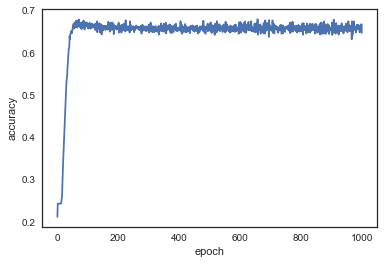

In [17]:
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [18]:
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names = classes))

                 precision    recall  f1-score   support

         Action       0.44      0.18      0.26       310
      Adventure       0.23      0.03      0.06       173
      Animation       0.43      0.17      0.24       193
         Comedy       0.46      0.24      0.31       734
          Crime       0.41      0.15      0.22       206
    Documentary       0.70      0.42      0.53       420
          Drama       0.58      0.36      0.45      1066
         Family       0.24      0.07      0.10       195
        Fantasy       0.18      0.03      0.06       119
        Foreign       0.00      0.00      0.00       104
        History       0.42      0.07      0.12        73
         Horror       0.55      0.26      0.35       255
          Music       0.75      0.44      0.56       238
        Mystery       0.25      0.02      0.03       115
        Romance       0.38      0.11      0.17       339
Science Fiction       0.58      0.18      0.27       119
       TV Movie       0.08    